In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# An end-to-end detector for lung cancer

In this notes we will consider the problem of **automatic detection of malignant tumors in the lungs**. To do so we will develop a program that will take three-dimensional computed tomography (CT) scans of human torsos as input and produce as output the location of suspected malignant tumors, if any exist.

## Requirements

* A GPU with at least 8 GB of RAM, for reasonable training speeds.
* At least 220 GB of free disk space, to store the raw training data, cached data, and trained models.

## Learning about the problem space

Before digging into the solution of the problem, we need to learn a bit about the area on which our problem lies. In this case we will cover some basics concept on CT scans, nodules, KG.

### CT scans

Since CT scans are the way our input data is presented, it's worth studying what they are and some of their characteristics. To begin with, **Computed Tomography (CT) scans** are 3D X-rays, represented as a 3D array of single channel data. So they look as an stacked set of grayscale PNG images. They are composed of **voxels** (3D equivalent of pixels), each having a numeric value that corresponds to the radiodensity of the matter contained inside, which is a function of both mass density and atomic number of the material. Most visualizations of that data show high-density material like bones and metal implants as white, low-density air and lung tissue as black, and fat and tissue as various shades of gray.

<img src="Images/young_witten_edward.jpg" width="100"/>

CT scan voxels are expressed in Hounsfield units (HU): air is –1,000 HU (~ 0 g/cc), water is 0 HU (1 g/cc), and bone is at least +1,000 HU (2–3 g/cc). Additionaly, the position of the voxels in a CT scans are usually described using the **patient coordinate system** (X,Y,Z) measured in millimiters, as shown in the image

<img src="Images/young_witten_edward.jpg" width="100"/>

These voxels usually vary in size between CT scans; typically, they are not cubes. Instead, they can be 1.125 mm × 1.125 mm × 2.5 mm or similar. 

### Nodules

Apart from the type of data we have, we also need to learn some specifics about cancer and radiation oncology. A mass of tissue made of proliferating cells in the lung is a **tumor**. A tumor can be **benign** or **malignant**, in which case it is also referred to as **cancer**. A small tumor in the lung (just a few millimeters wide) is called a **nodule**. About 40% of lung nodules turn out to be malignant—small cancers. In figure **XXX**, we can see a stereotypical example of a malignant nodule.

<img src="Images/young_witten_edward.jpg" width="100" />


## Strategy

In order to solve the entire problem (i.e. go from examining a whole-chest CT scan to giving the patient a lung cancer diagnosis.), we will brake it into five smaller and simpler problems depicted in figure **XXX**. Each step will take raw materials (data) and/or output from previous steps, perform some processing, and hand off the result to the next station down the line. The five main steps are:

1. **Data-loading and Data-processing**: Load our raw CT scan data into a form that we can use with PyTorch.
1. **Segmentation**: Identify the voxels of potential tumors in the lungs.
1. **Grouping**: Group interesting voxels into lumps, that is, candidate nodules.
1. **Classification**: Classify candidate nodules as actual nodules or non-nodules using 3D convolution.
1. **Diagnosis**: Diagnose the patient using the combined per-nodule classifications. If there is at least one malignant tumor we classify the patient as having cancer.


<img src="Images/young_witten_edward.jpg" width = "100" />

The form in which the end-to-end problem is presented here assumes that we've already built and trained all of the requisite models. The training processes are problems on their own and will be addressed later.

## Data-loading and Data-processing

This corresponds to step 1 of our strategy. Our goal here is to be able to produce a training sample given our inputs of raw CT scan data and a list of annotations for those CTs.

### Raw data

In order to train and test the models we will be using the [LUNA 2016 dataset](https://luna16.grand-challenge.org/Description) which contains CT scans, as well as human-annotated outputs for classification and
grouping. The data comes from the LUNA (LUng Nodule Analysis) Grand Challenge, which consists of two tracks: “Nodule detection (NDET),” (similar to our step 2) and “False positive reduction (FPRED),” (our step 4). The whole data takes 120 GB of space when uncompressed. On top of that we'll need another 100 GB or so of cache space to store smaller chunks of data so that we can access it more quickly than reading in the whole CT. The data comes in 10 subsets, aptly named `subset0` through `subset9`. In addition, we need the `candidates.csv` and `annotations.csv` files.

The 10 subsets have about 90 CT scans each (888 in total). For each CT scan, the data comes in two files: a `.mhd` file containing metadata header information, and a `.raw` file containing the raw bytes that make up the 3D array. Each file’s name starts with a unique identifier called the **series UID**.

The candidates file contains information about all lumps that potentially look like nodules in the form of (seriesuid, X, Y, Z, class) where class is a boolean for nodule (1) or non-nodule (0).

The annotation file contains information about some of the candidates that have been flagged as nodules in the form of (seriesuid, X, Y, Z, diameter). The diameter (mm) information is very useful, since we can use it to make sure our training and validation data includes a representative spread of nodule sizes. Without this, it’s possible that our validation set could end up with only extreme values, making it seem as though our model is underperforming.

All files come in the millimiter-based coordinate system (X,Y,Z).

### Unifying human-annotated data

Leaving the CT scan data for the moment, here we will create a funtion `getCandidateInfoList` that will return a cleaned and unified version of the candidates + annotations files. More precisely, the function outputs a list of (named) tuples, each containing information of a different candidate in the form of 
(isNodule_bool, candidateDiameter_mm, series_uid, candidateCenter_xyz,). The returned list is sorted by diameter in decreasing order. This sorting ensures that when we take a slice of the data, that slice gets a representative chunk of the actual nodules with a good spread of nodule diameters. Its values are cached with the `@functools.lru_cache` decorator and the reason why it's going to be explained later on.

### Loading individual CT scans

We create the `Ct` class such that its objects are individual CT scan. Each of them has to be initialized with the corresponding series_uid. A `Ct` object has the corresponding CT scan data in a NumPy array format, useful information about its coordinate system, as well as the `GetRawNodule` method which allows as to get a small cubic crop of the data centered around the desired nodule's center. A lot of things happen inside this class so a few comments are in order:

* The native file format for CT scans is DICOM yet LUNA converted the data into the MetaIO format, which is easier to use. In order to go from MetaIO to NumPy arrays we will use a parser `SimplerITK`. 

* At some point in the code we discard every voxel with HU < -1000 (everything outside of the patient, air, etc.) and HU > 1000 (we don't care about bones, metal, etc.).

* All the data we loaded is expressed in a millimiter-based coordinate system (X,Y,Z), so we need to transform it to the voxel-address-based coordinate system (I,R,C), denoting index, row and column. In order to do so we need to use a metadata stored in the header of the DICOM files, which defines the relationship between the CT array and the patient coordinate system. In particular, we will use the `.GetOrigin()` (origin of CT scan data in (X,Y,Z)), `GetSpacing()` (voxels' sizes) and `GetDirection()`(rotation matrix to align (X,Y,Z) and (I,R,C) systems) modules from `SimplerITK`. With this information we can go from (X,Y,Z) to (I,R,C) and vice-versa by using the two auxiliary functions `xyz2irc` and `irc2xyz` respectively.

* The `getRawNodule` function takes the center of a candidate in (X,Y,Z), as well as a width in voxels. It returns a cubic chunk of CT, as well as the center of the candidate in (I,R,C). This function produce a fixed-size array containing the candidate nicely centered so it becomes really useful to analyze one candidate at a time, and it will be used as input to our classifier later on.

### Dataset implementation

From each `Ct` instance we can get hundreds of different samples in the form of cubic chunks of data centered around each nodule candidate. We will create a `LunaDataset` class that will normalize those samples, flattening each CT’s nodules into a single collection from which samples can be retrieved without regard for which `Ct` instance the sample originates from. As usual, this class must be a subclass of Pytorch `Dataset` Class implementing `__len__` and `__getitem__`. The former counts the number of candidates in disk and the latter returns the information of a candidate in the form of (cube of data centered at candidate, (not is_Nodule, is_Nodule), series_uid, center_irc), where all numpy arrays were transformed to Tensors.

Inside `__init__` we have some parameters to handle training and validation sets. The parameter `val_stride` is used to specify every how many samples we send the current sample to the validation set. The `isValSet_bool` parameter is used to determine whether we should keep only the training data, the validation data, or everything. If we pass in a truthy `series_uid`, then the instance will only have nodules from that series.

### Caching

Since there are several candidates for each same CT scan, we need to do some on-disk caching to avoid having to read an entire CT scan from disk for every sample. To do so we’re caching the `getCt` and `getCtGetRawCandidate` return value in memory.

For the former we use the `@functools.lru_cache` decorator so we can repeatedly ask for the same `Ct` instance without having to reload all of the data from disk. (The same holds for `getCandidateInfoList` presented before!) That’s a huge speed increase in the case of repeated requests. (However, we’re only keeping _one_ CT in memory, so cache misses will be frequent if we’re not careful about access order!)

For the second function, its output values are cached to disk using the Python library `diskcache`. The reason why we use a different caching function is... **We’ll discuss why we have this specific caching setup in chapter 11. UNDERSTAND THIS LATER AND ADD IT HERE**

**TODO:** 
* Can I replace all the super weird caching with something simpler?

### Quick visualization of the data

During the data-loading and data-processing process we express the same data in different ways. Here we explore and visualize how some of those files look like.

In [3]:
from data_set import getCandidateInfoList, Ct, getCt, LunaDataset
from visualization import showCandidate

To begin with, let's look at the raw data comming from human-annotated files. These correspond to the annotations of the whole dataset and not to the ones we have on disk only. 

In [4]:
candidates_pd = pd.read_csv('data/candidates.csv')
print(f"Number of candidates: {len(candidates_pd)}\nExample:\n", candidates_pd[:1])

annotations_pd = pd.read_csv('data/annotations.csv')
print(f"\nNumber of Annotated nodules: {len(annotations_pd)}\nExample:\n", annotations_pd[:1])

Number of candidates: 551065
Example:
                                            seriesuid  coordX  coordY  coordZ  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  -56.08  -67.85 -311.92   

   class  
0      0  

Number of Annotated nodules: 1186
Example:
                                            seriesuid      coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421 -175.319272   

       coordZ  diameter_mm  
0 -298.387506     5.651471  


Then, let's explore the output of the `getCandidateInfoList` function and plot an histogram to estimate the distribution of nodule diameters in our dataset.

Candidates: 80206      
Nodules: 173


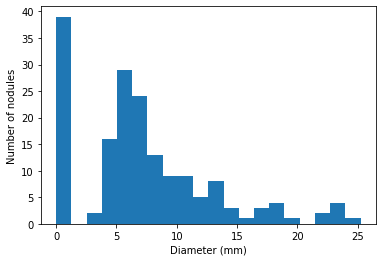

In [5]:
%matplotlib inline
candidateInfo_list = getCandidateInfoList(requireOnDisk_bool=True)  # candidates in disk only
positiveInfo_list = [x for x in candidateInfo_list if x[0]]  # nodules
diameter_list = [x[1] for x in positiveInfo_list]
print(f"Candidates: {len(candidateInfo_list)}\
      \nNodules: {len(positiveInfo_list)}")
# histogram for the diameters of positive candidates (nodules)
plt.hist(diameter_list, 20)
plt.xlabel("Diameter (mm)")
plt.ylabel("Number of nodules")
plt.show()

Let's take a single positive candidate (nodule) as an example and let's see how it's represented over the different classes and functions.

In [6]:
nodule = positiveInfo_list[0]

From the output of `getCandidateList`:

In [7]:
print(nodule)

CandidateInfoTuple(isNodule_bool=True, diameter_mm=25.23320204, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273', center_xyz=(63.4740118048, 73.9174523314, -213.736128767))


We can also look at elements of the `Ct` class by creating an instance of that class and using `getRawCandidate` to get an specific candidate. In this format the candidate is represent by a tuple containing a chunck of data surounding the nodule as a 3D array and its center location in IRC system.

In [8]:
nodule_uid = nodule[2]  # series_uid of ct scan from which nodule comes
nodule_center = nodule[3]
ct_a = Ct(nodule_uid)  # ct scan as an elemnet of the Ct class
nodule_a = ct_a.getRawCandidate(nodule_center, (32,48,48)) # the last argument is the width of the cuboid
print(nodule_a, nodule_a[0].shape)

(array([[[-673., -779., -869., ..., -868., -826., -840.],
        [-719., -778., -787., ..., -825., -778., -799.],
        [-766., -759., -672., ..., -794., -742., -784.],
        ...,
        [-705., -692., -733., ...,  225.,  322.,  393.],
        [-668., -655., -672., ...,  611.,  576.,  503.],
        [-637., -638., -650., ...,  576.,  426.,  323.]],

       [[-814., -844., -868., ..., -816., -818., -833.],
        [-874., -865., -839., ..., -815., -827., -844.],
        [-919., -885., -819., ..., -838., -827., -845.],
        ...,
        [-760., -750., -713., ...,   -5.,   11.,   -4.],
        [-717., -725., -676., ...,  108.,  110.,   61.],
        [-693., -692., -679., ...,  278.,  219.,  165.]],

       [[-951., -954., -947., ..., -872., -864., -858.],
        [-949., -953., -941., ..., -853., -846., -850.],
        [-928., -940., -920., ..., -827., -823., -833.],
        ...,
        [-698., -727., -761., ...,  -66.,  -23.,  -15.],
        [-698., -698., -712., ...,  -29.,   

With the nodule in this format we visualize it using the `showCandidate()` function.

900 training samples
1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273 0 False [0, 1, 2, 3, 4]


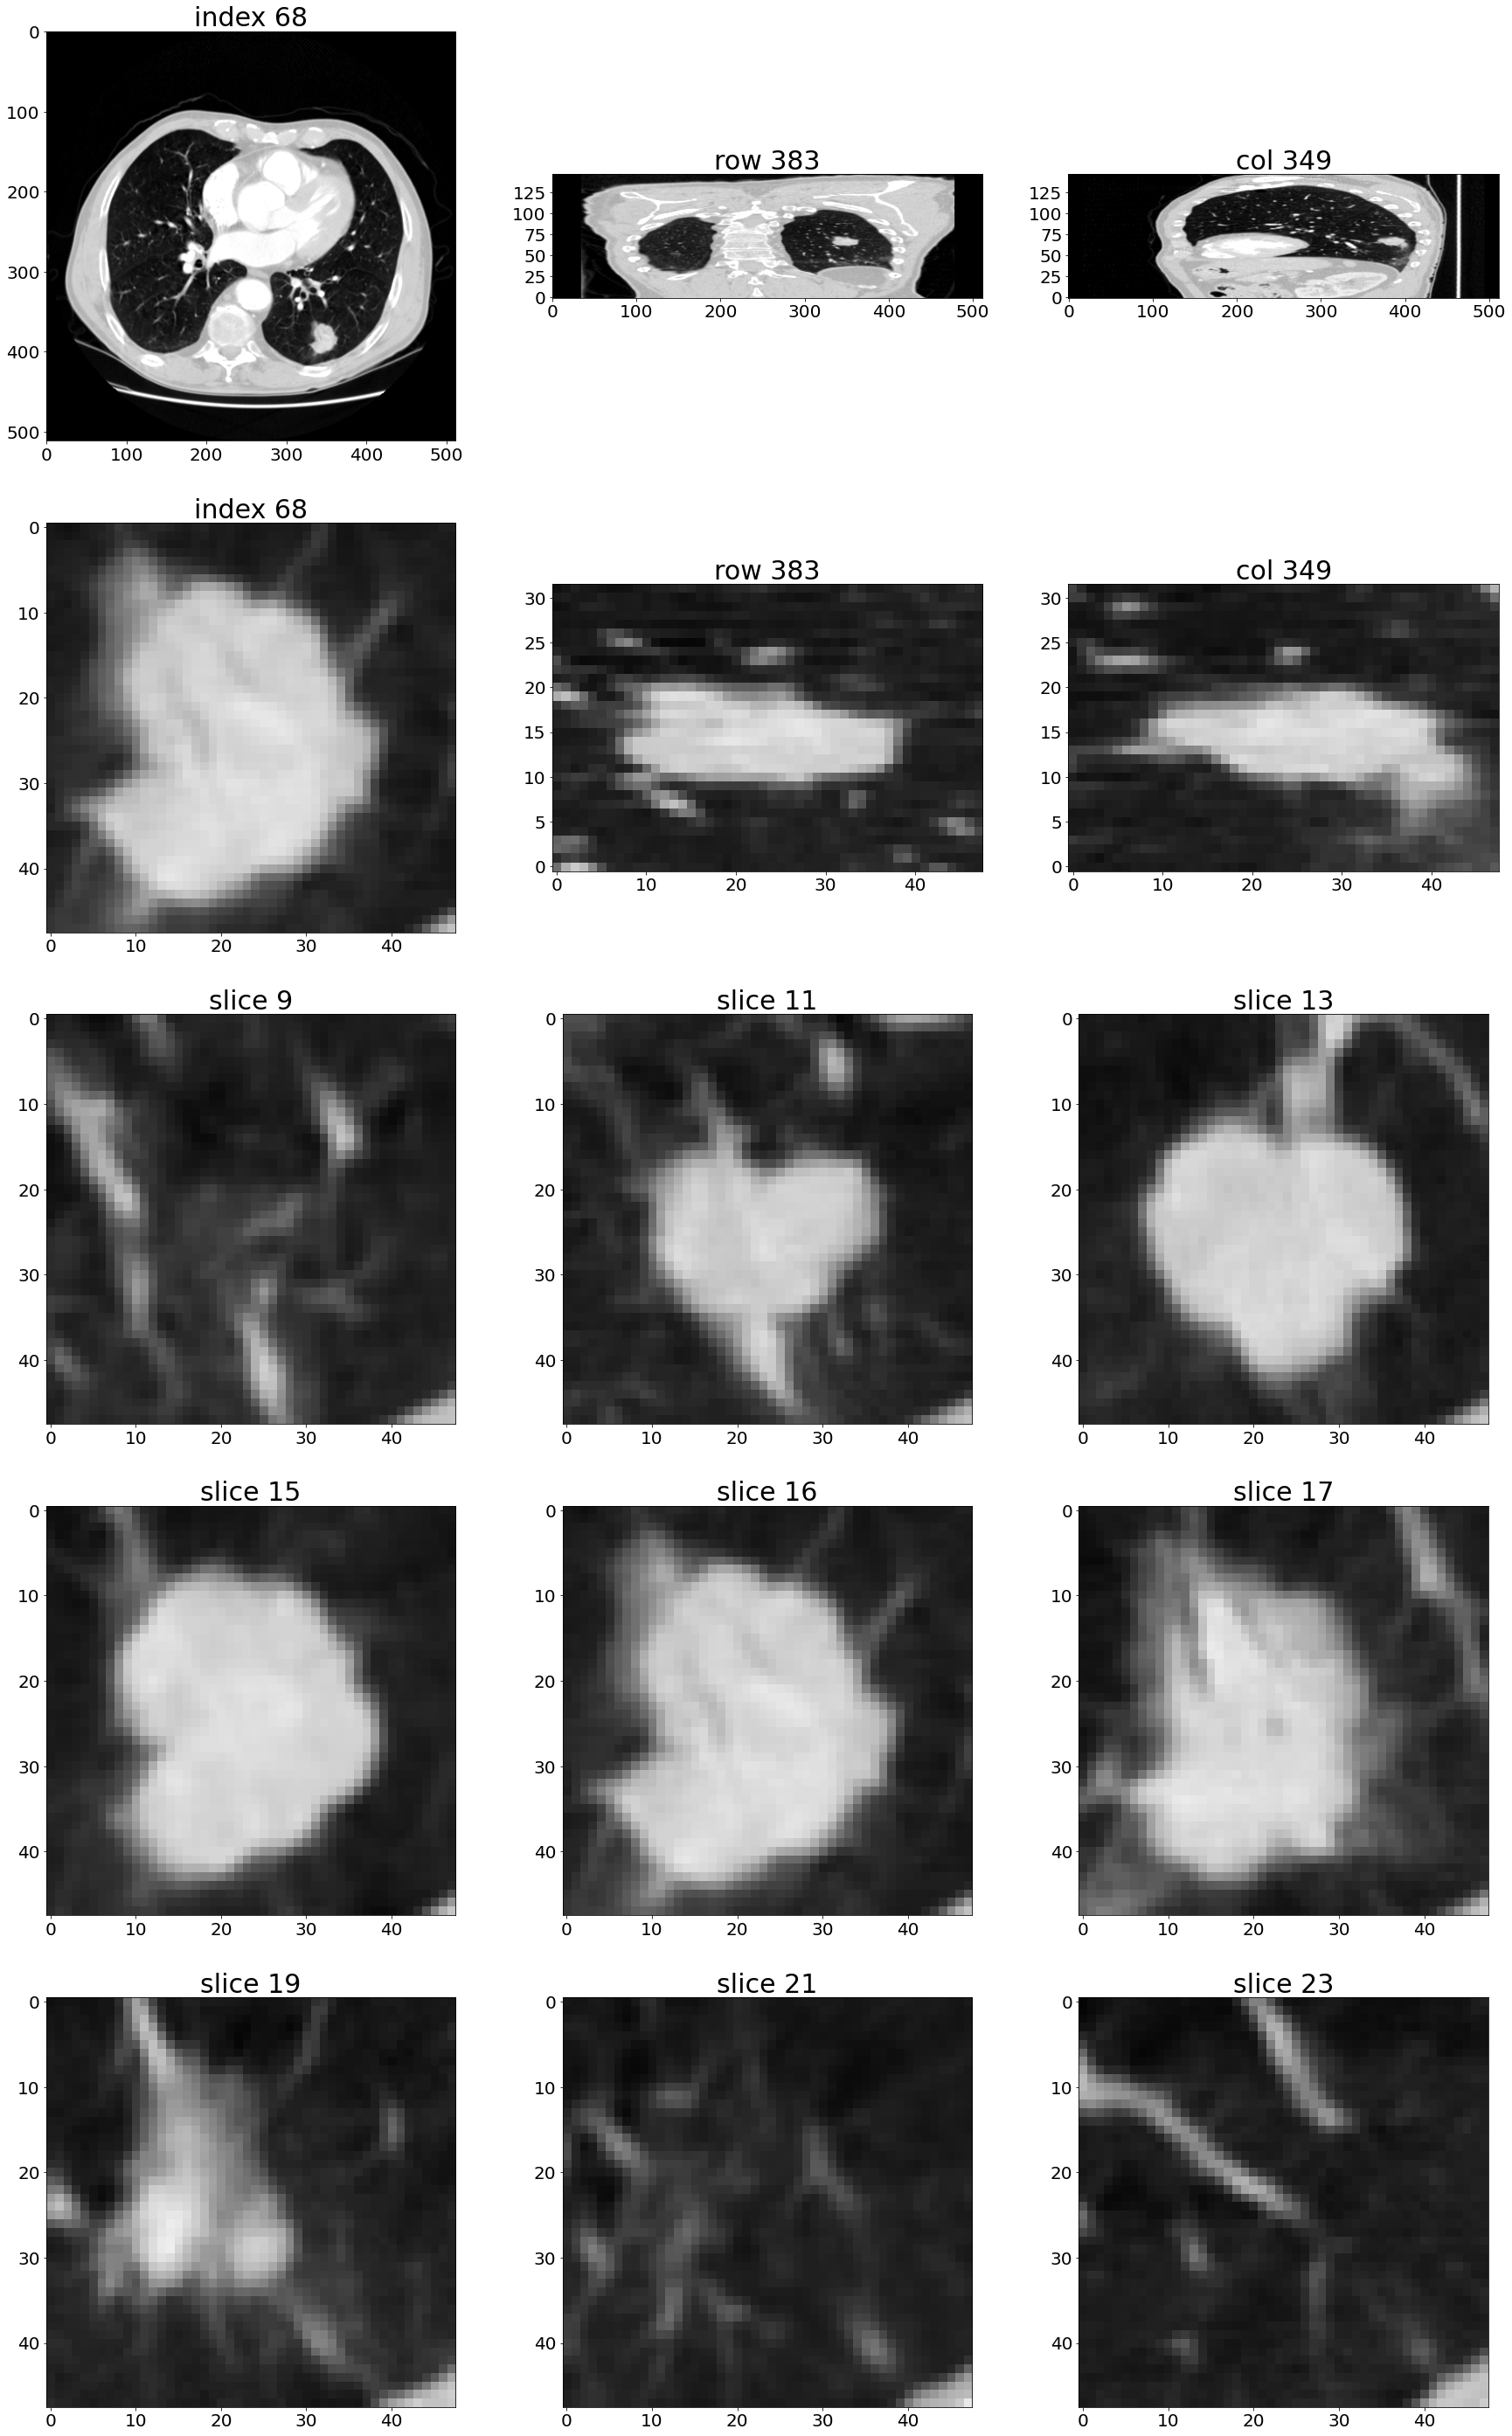

In [9]:
%matplotlib inline
showCandidate(nodule_uid)

As we explained before, the `Ct` class and `getRawCandidate()` method have their cached version `getCt()` and `getCtRawCandidate()`. Obviously their outputs look exactly the same as the ones we just showed for the original objects, but the increse in time is huge.

In [10]:
%%time
Ct(nodule_uid)

CPU times: user 76.9 ms, sys: 173 ms, total: 249 ms
Wall time: 248 ms


In [11]:
getCt(nodule_uid) # we have to load it once at least so to store it in cache memory

In [12]:
%%time
getCt(nodule_uid)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.39 µs


We can also look at an element of the `LunaDataset()`. To do so we can create a whole data set for all in-disk CT scans by calling `LunaDataset()` or we can restrict to samples coming from a single scan. For the latter we pick the series_uid to which our previous nodule belongs. Just this single ct scan contains several samples (candidates) and we will pick just one to show how it looks.

KG FIX THIS UNDERSTAND HOW CACHE WORKS

In [13]:
ct_ds = LunaDataset(series_uid=nodule_uid)
candidate_t = ct_ds[0]
print(candidate_t, candidate_t[0].shape)

900 training samples
(tensor([[[[-673., -779., -869.,  ..., -868., -826., -840.],
          [-719., -778., -787.,  ..., -825., -778., -799.],
          [-766., -759., -672.,  ..., -794., -742., -784.],
          ...,
          [-705., -692., -733.,  ...,  225.,  322.,  393.],
          [-668., -655., -672.,  ...,  611.,  576.,  503.],
          [-637., -638., -650.,  ...,  576.,  426.,  323.]],

         [[-814., -844., -868.,  ..., -816., -818., -833.],
          [-874., -865., -839.,  ..., -815., -827., -844.],
          [-919., -885., -819.,  ..., -838., -827., -845.],
          ...,
          [-760., -750., -713.,  ...,   -5.,   11.,   -4.],
          [-717., -725., -676.,  ...,  108.,  110.,   61.],
          [-693., -692., -679.,  ...,  278.,  219.,  165.]],

         [[-951., -954., -947.,  ..., -872., -864., -858.],
          [-949., -953., -941.,  ..., -853., -846., -850.],
          [-928., -940., -920.,  ..., -827., -823., -833.],
          ...,
          [-698., -727., -761

## Segmentation

This corresponds to step 2 of our strategy... KG

## Grouping

This corresponds to step 3 of our strategy. We need to find a way to tell our classifier where to look. To do this, we are going to take raw CT scans and find everything that might be a nodule. To find these possible nodules, we have to flag voxels that look like they might be part of a nodule, a process known as segmentation. With this model we'll be able to perform per-pixel labeling, or segmentation.

For this project, we will be using semantic segmentation, which is the act of classifying individual pixels in an image using labels. This takes the form of a label mask or heatmap that identifies areas of interest. We will have a simple binary label: true values will correspond to nodule candidates, and false values mean uninteresting healthy tissue. More advanced techniques would involve using instance segmentation or object detection, yet they won't be used here for simplicity.

As opposed to plane binary classficiation, which can tell us if an object is present in an image or not, segmentation deals with the problem of specifying where that object is present in the image by selecting all pixels which belong to it. For classification taking images as inputs, we usually use a series of ConvNets together with downsampling to shrink more and more the information until reducing it to a bunch of few pixels, pass it to a fully-connected layer and then return as many output neurons as classes. For segmentation, however, we need a model that performs operations to the input yet preserving the original size. One simple model to use for segmentation would have repeated convolutional layers without any downsampling. The problem with this is that, wihout downsampling, the deeper layers has a very limited receptive field. The classification model uses each downsampling layer to double the effective reach of the following convolutions; and without that increase in effective field size, each segmented pixel will only be able to consider a very local neighborhood.  

So the question remains: how can we improve the receptive field of an output pixel while maintaining a 1:1 ratio of input pixels to output pixels?

One common solution is to use a technique called upsampling which takes an image of a given resolution and
produces an image of a higher resolution.

### The U-Net architecture

The U-Net architecture is a design for a neural network that can produce pixelwise output and that was invented for semantic segmentation. One of its implementations can be seen in figure XXX

<img src="Images/young_witten_edward.jpg" width = "100" />

Rather than implementing a custom U-Net segmentation model from scratch, we’re going to appropriate
an existing implementation from an open source repository on GitHub [here](https://github.com/jvanvugt/pytorch-unet). However, instead of using it just right how it comes, we will make some changes appropiate for our particular purpose. First, we’re going to pass the input through batch normalization. Second, we pass the output through an `nn.Sigmoid` layer to restrict the output to the range $\[0, 1\]$. Third, we will reduce the total depth and number of filters we allow our model to use. Finally, our output will be a single channel, with each pixel of output representing the model’s estimate of the probability that the pixel in question is part of a nodule. All these modifications will be encoded in the class `UNetWrapper`.

The original U-Net implementation did not use padded convolutions which means that non of the input pixels that lead to the output image were padded or artificially fabricated in any way. There are two problems with us taking the same pixel-perfect approach for our problem: 

1) The first issue is that the sizes of the input and output patches for U-Net are very specific, only certain input sizes will work. The U-Net paper used 572 $\times$ 572 image patches, which resulted in 388 $\times$ 388 output maps. This input is bigger than our $512 \times 512$. We will address this issue by setting the `padding` flag of the U-Net constructor to `True`. This will mean we can use input images of any size, and we will get output of the same size. We may lose some fidelity near the edges of the image, since the receptive field of pixels located there will include regions that have been artificially padded, but that’s a compromise we decide to live with.

1) The second problem is that our original input is 3D, and not 2D as U-Net expects. In order to cure this, instead of trying to do things in 3D, we’re going to treat each slice as a 2D segmentation problem and cheat our way around the issue of context in the third dimension by providing neighboring slices as separate channels. Instead of the traditional “red,” “green,” and “blue” channels that we’re familiar with from photographic images, our main channels will be “two slices above,” “one slice above,” “the slice we’re actually segmenting,” “one slice below,” and so on.

### Ground truth for segmentation

In principle we have a mismatch between the human-annotated data for the position of candidates (ground truth) and the output of our model (prediction). We want to replace the former for a per-voxel mask that indicates whether any given voxel is part of a nodule. We will proceed in steps:

1) Bounding boxes: We are going to begin by converting the nodule locations that we have into bounding boxes that cover the entire nodule (note that we’ll only do this for actual nodules). If we assume that the nodule locations are roughly centered in the mass, we can trace outward from that point in all three dimensions until we hit low-density voxels, indicating that we’ve reached normal lung tissue (which is mostly filled with air). This algorithm is implemented in `Ct.buildAnnotationMask` where is important to note that we stop incrementing the very approximate radius values after the density drops below threshold, so our bounding box should contain a one-voxel border of lowdensity tissue (at least on one side; since nodules can be adjacent to regions like the lung wall, we have to stop searching in both directions when we hit air on either side!) Then we build this inside a function `buildAnnotationMask` which first loop over all nodules. For each nodule, we perform the search explained earlier and thenin a Boolean tensor `boundingBox_a`, we mark the bounding box we found. After the loop, we do a bit of cleanup by taking the intersection between the bounding-box mask and the tissue that’s denser than our threshold of $-700$ HU. That’s going to clip off the corners of our boxes (at least, the ones not embedded in the lung wall), and make it conform to the contours of the nodule a bit better. After this procedure, the returned mask look like in figure XXX

<img src="Images/young_witten_edward.jpg" width = "100" />

1) Calling mask during CT initialization: Here we embed these previous masks into our CT object and collect the set of unique array indexes that have at least one voxel of the nodule mask (We’ll use this to shape the data we use for validation.)

1) Cleanning up annotation data: It turns out that several of the candidates listed in candidates.csv are present multiple times. Luckily for us, [here](https://github.com/deep-learning-with-pytorch/dlwpt-code/blob/master/data/part2/luna/annotations_with_malignancy.csv) we can find the already cleaned version of the annotations where they deduplicated the nodules. 

    TODO: Why do they use both files instead of just the new one?

### Luna2dSegmentationDataset

For this dataset we will have two classes: one acting as a general base class suitable for validation data, and one subclassing the base for the training set, with randomization and a cropped sample.

The data that we produce will be two-dimensional CT slices with multiple channels. The extra channels will hold adjacent slices of CT. For validation, we’ll need to produce one sample per slice of CT that has an entry
in the positive mask, for each validation CT we have. To do this we introduce a new function that caches the size of each CT scan and its positive mask to disk. We need this to be able to quickly construct the full size of a validation set without having to load each CT at `Dataset` initialization.

In order to split between training and validation sets, an entire CT scan, along with all nodule candidates it contains, will be in either the training set or the validation set.

For validation we’re going to have two different modes we can validate our training with. First, when `fullCt_bool` is `True`, we will use every slice in the CT for our dataset. This will be useful when we’re evaluating end-to-end performance, since we need to pretend that we’re starting off with no prior information about the CT. We’ll use the second mode for validation during training, which is when we’re limiting ourselves to only the CT slices that have a positive mask present.

Our `__getitem__` implementation will retrieve our data in three different forms. First, we have the full slice of
the CT, as specified by a `series_uid` and `ct_ndx`. Second, we have a cropped area around a nodule, which we’ll use for training data. Finally, the `DataLoader` is going to ask for samples via an integer `ndx`, and the dataset will need to return the appropriate type based on whether it’s training or validation.

### Training and validation data

Before we get into the implementation for our training dataset, we need to explain why our training data will look different from our validation data.  Instead of the full CT slices, we’re going to train on $64 \times 64$ crops around our positive candidates.  These $64 \times 64$ patches will be taken randomly from a $96 \times 96$ crop centered on the nodule. We will also include three slices of context in both directions as additional “channels” to our 2D segmentation. We are doing this because apparently the authors of the book already tried other formats and after some experimentation they came up with this being a convenient approach. One could also try to train on the full CT slice instead of crops but apprently that is unstable essentially due to a class-balancing issue (the small portion of the whole slice that correspond to a nodule gets lost on all non-nodule pixels!) By training on
crops, we’re keeping the number of positive pixels the same and reducing the negative pixel count by several orders of magnitude.

### Augmenting on the GPU

Different from the classficiation problem, here we’re going to augment our data on the GPU. We’re going to move data augmentation to the GPU. This will keep our CPU usage light, and the GPU will easily be able to accommodate the additional workload. Far better to have the GPU busy with a small bit of extra work than idle waiting for the CPU to struggle through the augmentation process.

### Training process

For the training process for segmentation we will use the Dice Loss and Adam as optimizer. We'll also log images for visual inspection of the segmentation to TensorBoard, peform some metrics logging and save our best model based on the validation.

The [Dice Loss](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) is a common loss metric for segmentation tasks. One advantage of using Dice loss over a per-pixel cross-entropy loss is that Dice handles the case where only a small portion of the overall image is flagged as positive. Since we want a loss to minimize, we’re going to take the Dice ratio and subtract it from 1.

## Classification

This corresponds to step 4 of our strategy. The idea in this step is to build and train a model to classify candidates into nodules or non-nodules. We'll embed this model into a fully fledged command-line application. It will parse command-line arguments, have a full-featured --help command, and be easy to run in a wide variety of environments. All this will allow us to easily invoke the training routines from both Jupyter and a Bash shell.

### The Luna Training App

All the program is encoded into a fully fledged command-line application, the `LunaTrainingApp` class.

###### `__init__`

The first thing we do in `__init__` is to build a parsing-argument structure to accept command-line arguments. To do so we use the standard `argparse` library, the recommended command-line parsing module in the Python standard library. Check [here](https://docs.python.org/3/howto/argparse.html#id1) for a nice tutorial of the library! The structure is pretty standard and general and can be used for any other projects. In this way we can configure the application separately from invoking it. The arguments to be taken from the app are just the number of workers processes (for background data loading), the number of batches, and the number of epochs. Apart from that, `__init__` also includes information on the current device (gpu or cpu) as well as initializes the model and optimizer by calling `initModel` and `initOptimizer`.

###### `initModel`

The `initModel` method just initilializes the model by using `LunaModel` in `model.py` file (we'll cover this file in the next subsection) and send its parameters to the corresponding device, namely cpu, gpu or multiple gpus.

###### `initOptimizer`

The `initOptimizer` method just initializes the optimizer. Here we can use SGD, Adam or any other optimizer offered in `torch.optim`. For an extense list of optimizers, check [the official documentation](https://pytorch.org/docs/stable/optim.html#algorithms). 

###### `initDataLoader`

Then we have `initDataLoader` which initializes the dataloaders from the datasets we created previously in `data_set.py`. As a quick reminder, in the later we used the `LunaDataset` class as a bridge between raw data to the tensors that the PyTorch building blocks expect. In particular, we went from 3D CT scans + annotations to a tuple containing, among other elements, a 4-dimensional Pytorch tensor. Each tuple corresponds to a single sample, and the tensor inside it is a chunk of data of the form \[C, D, H, W\], number of channels (1), depth, height and width. Since usually we have acces to parallel calculations, training on single samples at a time is an inefficient use of computing resources. That's why we should group sample tuples together into a batch tuple and slice over the different samples inside with an extra N dimension. This batching is done by Pytorch `DataLoader` class. In particular, every batch tuple will contain a 5-dimensional Pytorch tensor of the form \[N, C, D, H, W\] where we added the fifth direction N that selects the sample inside the batch. These tensors come exactly in the format expected by the input of `LunaModel`.

###### `main`

The next function we have is `main`, where the magic happens. Here we train the model for all epochs, store the training and validation metrics, and display the results. After initializing the dataloaders we run a loop over epochs and for each of them we perform a series of steps:

* First we call the `doTraining` method which, as the name suggests, it trains the model by updating the parameters and also returns `trnMetrics_t`, which collects detailed per-sample metrics during training.
* Then we pass these metrics into the `logMetrics` function which KG.
* Then we repeat similar steps but using the validation dataloader. In this case we use `doValidation`, we obtain `valMetrics_t` and finally call `logMetrics` again.

##### `doTraining`

The juicy part of the `main` method, is encoded in the `doTraining` function. As we mentioned, this method takes care of training the model for a single epoch by following the standard procedure:

**For batch in train dataloader:**
>**Compute Loss (with `computeBatchLoss`)**

>**Apply Backprop to get gradients**

>**Update model's parameters by performing an optimizer step**

Apart from that, it also returns the per-sample training metrics for an entire epoch. They are initialized with zeros inside `doTraining` but filled with the relevant information after running `computeBatchLoss` in each batch.

###### `doValidation`

This function is very similiar to `doTraining` except that it doesn't train the model. So it only returns the per-sample validation metrics for an entire epoch, which are computed inside `computeBatchLoss` in each batch.

###### `computeBatchLoss`

Both `doTraining` and `doValidation` calls this function. The function returns the loss of a given batch, which is only used in `doTraining`, but at the same time stores the metrics in the `metrics_g` argument (which at the begining of each epoch is filled with zeros). The code inside this function is pretty simple. After unpacking the batch tuple, it pass the input through the model to get the logits and probabilities. Then, we use the loss function `nn.CrossEntropyLoss` to compare the logits to the actual labels, returning the loss of the batch.

Finally, we fill the metrics with the labels, probabilities (predictions) and loss of each sample inside the batch. This means that every call of `computeBatchLoss` stores per-sample metrics for a single batch. Inside `doTraining` and `doValidation` this functions is repeated for each batch in an epoch so, at the end, the final metrics will contain the information of an entire epoch. They will have three rows and as many columns as samples we have (in training and validation separately).

###### `logMetrics`

The last thing we do per epoch inside `main` is to log our performance metrics. Logging results and progress as we go is important to have full control of how our model behaves during training. The metrics we computed in `doTraining` and `doValidation` contains per-sample information about loss, labels and predictions (probabilities). With this information we can compute the percent correct and average loss per class for training and validation runs. This is exactly the purpose of `logMetrics`. The function begins by computing the masked arrays for predictions and lables that will let us limit our metrics to only the nodule (positive) or non-nodule (negative) samples. Next, we use those masks to compute some per-label statistics and store them in a dictionary, `metrics_dict`. Then, we log our results with three calls to `log.info`.

### Metrics and TensorBoard

xxx kg

### The model

In this subsection we cover the specific model we'll build for the classifier.

Classification models often have a structure that consists of a tail, a backbone (or body), and a head. 
The tail is the first few layers that process the input to the network and adapt it to the form expected by the backbone. The backbone typically contains the bulk of the layers, which are usually arranged in series of blocks. Finally, the head of the network takes the output from the backbone and converts it into the desired output form.

We implement these three structures in a `LunaModel` class, as a subclass of Pytorch `nn.Module` class:
* **Tail:** a simple `nn.BatchNorm3d` normalization that will shift and scale our input so that it zero mean and unit standard deviation.
* **Body:** four repeated blocks, with the block implementation pulled out into the separate `nn.Module` subclass. Each of these blocks correspond to the chain output = MaxPool(Relu(Conv3D(Relu(Conv3D(input)))).
* **Head:**  a fully connected layer followed by a call to `nn.Softmax`. 

As usual, all building blocks are initialized in `__init__` and then nested together in a `forward` pass. 

In the former we also initialize the parameters using the `_init_weights` method. What this function does is to guarantee that the network’s parameters exhibit certain desired properties from the very beginning. While many normalization techniques can be used to keep layer outputs well behaved, one of the simplest is to just make sure the network’s weights are initialized such that intermediate values and gradients become neither unreasonably small nor unreasonably large. This is implemented manually inside `_init_weights`.

The return value of the forward method includes, not only the probabilities produced by softmax, but also the raw logits coming from the output of the network prior to being normalized by the softmax layer. We’ll use the logits when we calculate the `nn.CrossEntropyLoss` during training and we’ll use the probabilities for when we want to actually classify the samples.

### F1 score as a good metric for the problem

As it stands, the classifier works but it's not perform well at all. It's getting almost 100% of accuracy in all samples and the negative class but 0% in the positive class. In this scenarios, considering the percentage of correct predictions for _all_ samples simultaneously is meaningless, since almost all samples are negative and then we cannot see how poorly our network is performing on the other class! The reason why our model is performing so poorly in this positive class is that there are much more negative samples than positive, so our model is learning just to classify everything as negative! By doing so, it can still achieve a very low loss value, so it doesn't bother in classifying correctly the rest of samples. Even though the model seems not to care at all about this, this misclassfication of all positive samples is what makes our lung cancer detector totally useless... for now.

In order to solve this issue we need to deal with the false-positive (when a non-nodule is classified as a nodule) and false-negative (when a real nodule goes undetected) cases. With those two concepts we can build the quantities

* **Recall (sensitivity):** is the ratio of the true positives to the union of true positives and false negatives.
* **Precision:** is the ratio of the true positives to the union of true positives and false positives.

To improve sensitivity one should minimize false negatives. A perfect sensitivy of $1.0$ can be easily achieved by classifying every sample as positive (false negatives = 0). In order to improve precision, one should minimize false positives. One can do so till the limit by classifying everything as negative. 

While neither precision nor recall can be the single metric used to grade our model, they are both useful numbers to have on hand during training. Both precision and recall are valuable metrics to be able to track during training, since they provide important insight into how the model is behaving. If either of them drops to zero, it’s likely that our model has started to behave in a degenerate manner. 

While useful, neither precision nor recall entirely captures what we need in order to be able to evaluate a model. It’s possible to game either one individually by manipulating our classification threshold, resulting in a model that scores well on one or the other but does so at the expense of any real-world utility. The generally accepted way of combining precision and recall is by using the [F1 score](https://en.wikipedia.org/wiki/F-score), defined as 
$$F_1 = 2 \frac{\text{Recall} \times \text{Precision}}{\text{Recall + Precision}} $$

and plotted in figure XXX. As with other metrics, the F1 score ranges between 0 (a classifier with no real-world predictive power) and 1 (a classifier that has perfect predictions).

<img src="Images/young_witten_edward.jpg" width = "100" />

The usefulness of the F1 metric relies on the fact that in order to maximize it, we need unavoidable to improve both quanties, recall and precision! Having at least one of them with a low value implies a low value for F1, regardless how high the other quantity is! One inmediate problem of this measure is that it's ill define for the singular case Recall = Precision = 0, which happens when there are no true positives classified at all.

### Balancing the data

Our data is wildly imbalanced. There’s a 400:1 ratio of positive samples to negative ones. That’s crushingly imbalanced! Instead, we’d like to have just as many positive samples as negative ones. Since our LUNA data has only a small, fixed number of positive samples, we’ll have to settle for taking the positive samples that we have and presenting them repeatedly during training. Also, this balanced version of the data should be present in each batch returned by the dataloader. We will not be doing any balancing for validation, however. Our model needs to function well in the real world, and the real world is imbalanced.

In order to implement the balancing of the data one could use the `sampler` option from `DataLoader`, in our case, however, since we have full control of the data set, we'll modify the `LunaDataset` class directly. We change it by presenting a balanced, one-to-one ratio of positive and negative samples for training. But of course not for the validation set! By doing so we'll definitely improve the performance of our program. However, it's going to be very prone to overfitting. This is because the balancing of the data occurs fictitiously by repeating the same few positive samples several times. By doing so, it's very easy for the model to "memorize" those positive examples, instead of learn a pattern. When comaparing with the unbalanced validation set (i.e. the real world) we get worse and worse results for the positive class!

### Preventing overfitting with data augmentation

As we just mentioned overfitting is usually due to having too few training samples when compared to the
ability of the model to just memorize the answers. Since we don't have acces to more real data than the one we got from the LUNA data set, the only remaining option is to create our own! To do so we _augment_ a dataset by applying synthetic alterations to individual samples, resulting in a new dataset with an effective size that is larger than the original. We are going to implement five specific types of data augmentation:

* Mirroring the image up-down, left-right, and/or front-back
* Shifting the image around by a few voxels
* Scaling the image up or down
* Rotating the image around the head-foot axis
* Adding noise to the image



KG

### XXX

For each CT data, our `Ct` class will consume the `.mhd` and `.raw` files and produce the 3D array, as well as the
transformation matrix to convert from the patient coordinate system (X,Y,Z) to the index, row, column coordinates (I,R,C).

By combining the nodule coordinate with coordinate system transformation information, we get the index, row, and column of the voxel at the center of our nodule.

Using the (I,R,C) coordinates, we can crop a small 3D slice of our CT data to use as
the input to our model. Along with this 3D sample array, we must construct the rest of
our training sample tuple, which will have the sample array, nodule status flag, series
UID, and the index of this sample in the CT list of nodule candidates. This sample
tuple is exactly what PyTorch expects from our Dataset subclass

### Logging

Logging is a means of tracking events that happen when some software runs. Logging calls in the code indicates that certain events have occurred by displaying a descriptive message which can optionally contain variable data. Events also have different importance levels, called the level or severity. There are 5 levels (in increasing order of severity):
* **`DEBUG`**: Detailed information, typically of interest only when diagnosing problems.
* **`INFO`**: Confirmation that things are working as expected.
* **`WARNING`**: An indication that something unexpected happened.

and two more related to errors. We can set the logging to one of these levels, which acts as the threshold for tracking (e.g. if we set the threshold to `DEBUG`, all of the messages will be printed.)

## TODO:

* Change from CSV reader to Pandas
* Can I use Pytorch directly for Augmentation?
* Merge unet and segmentation_model files into a single model file directly by applying the minimal modifications to the original UNet architecture (According to the licence, there is no problem at all in doing this while keeping the licence on top)
* Segmentation and classification dataset in a same place?

## References

* Deep Learning with Pytorch, [GitHub](https://github.com/deep-learning-with-pytorch/dlwpt-code)
* A nice place to learn [what caching is](https://towardsdatascience.com/how-to-speed-up-your-python-code-with-caching-c1ea979d0276)
* [Tutorial about logging](https://docs.python.org/3/howto/logging.html)